Starting from mucoco's split
1. mucoco+add: Add a fraction of unused data with label \in (0.0, 0.5). The fraction sampled for train/dev/test data is (count of label 0 data in train/dev/test) / (count of all label 0 data).
2. mucoco+addmore: Add all of unused data with label \in (0.0, 0.5). Add 90% of the data to train, 5% to dev, 5% to test.
3. mucoco+addall: Add all of unused data. (Label is \in [0.0, 0.5).) Add 90% of the data to train, 5% to dev, 5% to test.

In [5]:
# discretize toxicity columns and check distribution
# or simply check histogram
import pandas as pd
import seaborn as sns
import numpy as np
import torch

In [6]:
import os
os.getcwd()

'/home/hyeryungson/mucoco'

In [7]:
data_dir = './data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/'

## Read data

In [8]:
all_data = pd.read_csv(os.path.join(data_dir, 'all_data_simple.csv'))

In [9]:
# remove rows that have both text and toxicity duplicated
print('nrows before drop duplicates by text column ', all_data.shape[0])
print('nrows after drop duplicates by text column', all_data.drop_duplicates(subset=['comment_text', 'toxicity']).shape[0])
print('nrows to be dropped ', all_data.shape[0] - all_data.drop_duplicates(subset=['comment_text', 'toxicity']).shape[0])

all_data = all_data.drop_duplicates(subset=['comment_text', 'toxicity'])

nrows before drop duplicates by text column  1999516
nrows after drop duplicates by text column 1977803
nrows to be dropped  21713


In [13]:
all_data['toxicity_cat']=pd.cut(all_data['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)

In [7]:
# composition of toxicity label before deleting such dirty samples
def portion(x):
    return len(x)/len(all_data)
all_data.groupby('toxicity_cat').agg({'id': [len, portion]})

id          
                  len   portion
toxicity_cat                   
[0.0, 0.1)    1382741  0.699130
[0.1, 0.2)     177893  0.089945
[0.2, 0.3)     188465  0.095290
[0.3, 0.4)       6093  0.003081
[0.4, 0.5)      63108  0.031908
[0.5, 0.6)      79559  0.040226
[0.6, 0.7)      29662  0.014997
[0.7, 0.8)      16204  0.008193
[0.8, 0.9)      23878  0.012073
[0.9, 1.0)       5339  0.002699
[1.0, 1.1)       4861  0.002458

In [10]:
all_data = all_data.loc[~all_data['comment_text'].duplicated(keep=False)]

In [ ]:
all_data=all_data.rename(columns={'comment_text': 'text'})

In [155]:
# drop nan row
all_data = all_data.loc[~all_data['text'].isna(),:].copy()

In [14]:
def portion(x):
    return len(x)/len(all_data)
all_data.groupby('toxicity_cat').agg({'id': [len, portion]})

id          
                  len   portion
toxicity_cat                   
[0.0, 0.1)    1380237  0.701494
[0.1, 0.2)     175909  0.089404
[0.2, 0.3)     186505  0.094790
[0.3, 0.4)       5991  0.003045
[0.4, 0.5)      62370  0.031699
[0.5, 0.6)      78504  0.039899
[0.6, 0.7)      29088  0.014784
[0.7, 0.8)      15841  0.008051
[0.8, 0.9)      23287  0.011835
[0.9, 1.0)       5063  0.002573
[1.0, 1.1)       4774  0.002426

/tmp/ipykernel_2317888/936240274.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_data['toxicity'], kde=False)


<Axes: xlabel='toxicity'>

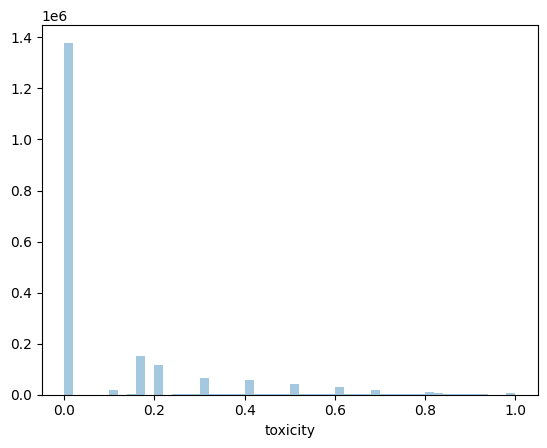

In [15]:
# highly imbalanced.
sns.distplot(all_data['toxicity'], kde=False)

## Set aside train, valid, test split of mucoco paper and add additional data (samples with (0, 0.5))

In [36]:
train0=pd.read_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/train_0.jsonl', lines=True)
train1=pd.read_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/train_1.jsonl', lines=True)

In [37]:
dev0=pd.read_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/dev_0.jsonl', lines=True)
dev1=pd.read_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/dev_1.jsonl', lines=True)

In [38]:
test0=pd.read_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/test_0.jsonl', lines=True)
test1=pd.read_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/test_1.jsonl', lines=True)

In [39]:
train0['split_mucoco'] = 'train'
train1['split_mucoco'] = 'train'
dev0['split_mucoco'] = 'dev'
dev1['split_mucoco'] = 'dev'
test0['split_mucoco'] = 'test'
test1['split_mucoco'] = 'test'

In [40]:
mucoco_splits=pd.concat([train0, train1, dev0, dev1, test0, test1], axis=0)
del train0, train1, dev0, dev1, test0, test1

In [51]:
all_data = all_data.merge(mucoco_splits, on='text', how='left')

In [52]:
all_data['split_mucoco'].fillna('not-used', inplace=True)

In [55]:
all_data.groupby('split_mucoco').size().sort_values()

split_mucoco
test           3960
dev            4004
train        317747
not-used    1652648
dtype: int64

In [61]:
all_data.groupby('toxicity_cat').agg({'id': [len, portion]})

id          
                  len   portion
toxicity_cat                   
[0.0, 0.1)    1390450  0.702830
[0.1, 0.2)     175909  0.088917
[0.2, 0.3)     186505  0.094273
[0.3, 0.4)       5991  0.003028
[0.4, 0.5)      62370  0.031526
[0.5, 0.6)      78959  0.039911
[0.6, 0.7)      29156  0.014737
[0.7, 0.8)      15848  0.008011
[0.8, 0.9)      23294  0.011774
[0.9, 1.0)       5070  0.002563
[1.0, 1.1)       4807  0.002430

In [63]:
prop_sampling=164527/1390450
prop_sampling_dev=2052/1390450
prop_sampling_test=1998/1390450

In [78]:
all_data.loc[(all_data['split_mucoco']=='not-used') & (all_data['toxicity_cat'].cat.codes!=0)].groupby('toxicity_cat').agg({'id': [len, portion]})

id          
                 len   portion
toxicity_cat                  
[0.0, 0.1)         0  0.000000
[0.1, 0.2)    175909  0.088917
[0.2, 0.3)    186505  0.094273
[0.3, 0.4)      5991  0.003028
[0.4, 0.5)     62370  0.031526
[0.5, 0.6)         0  0.000000
[0.6, 0.7)         0  0.000000
[0.7, 0.8)         0  0.000000
[0.8, 0.9)         0  0.000000
[0.9, 1.0)         0  0.000000
[1.0, 1.1)         0  0.000000

In [76]:
train_add=all_data.loc[(all_data['split_mucoco']=='not-used') & (all_data['toxicity_cat'].cat.codes!=0)].sample(frac=prop_sampling, random_state=999)

In [77]:
train_add.groupby('toxicity_cat').agg({'id': [len, portion]})

id          
                len   portion
toxicity_cat                 
[0.0, 0.1)        0  0.000000
[0.1, 0.2)    20613  0.010419
[0.2, 0.3)    22159  0.011201
[0.3, 0.4)      687  0.000347
[0.4, 0.5)     7513  0.003798
[0.5, 0.6)        0  0.000000
[0.6, 0.7)        0  0.000000
[0.7, 0.8)        0  0.000000
[0.8, 0.9)        0  0.000000
[0.9, 1.0)        0  0.000000
[1.0, 1.1)        0  0.000000

In [84]:
all_data.loc[all_data['id'].isin(train_add['id']), 'split_mucoco'] = 'train-add-hayley'

In [87]:
dev_add=all_data.loc[(all_data['split_mucoco']=='not-used') & (all_data['toxicity_cat'].cat.codes!=0)].sample(frac=prop_sampling_dev, random_state=999)

In [88]:
dev_add.groupby('toxicity_cat').agg({'id': [len, portion]})

id          
              len   portion
toxicity_cat               
[0.0, 0.1)      0  0.000000
[0.1, 0.2)    228  0.000115
[0.2, 0.3)    251  0.000127
[0.3, 0.4)      7  0.000004
[0.4, 0.5)     75  0.000038
[0.5, 0.6)      0  0.000000
[0.6, 0.7)      0  0.000000
[0.7, 0.8)      0  0.000000
[0.8, 0.9)      0  0.000000
[0.9, 1.0)      0  0.000000
[1.0, 1.1)      0  0.000000

In [92]:
all_data.loc[all_data['id'].isin(dev_add['id']), 'split_mucoco'] = 'dev-add-hayley'

In [94]:
test_add=all_data.loc[(all_data['split_mucoco']=='not-used') & (all_data['toxicity_cat'].cat.codes!=0)].sample(frac=prop_sampling_test, random_state=999)

In [95]:
test_add.groupby('toxicity_cat').agg({'id': [len, portion]})

id          
              len   portion
toxicity_cat               
[0.0, 0.1)      0  0.000000
[0.1, 0.2)    201  0.000102
[0.2, 0.3)    254  0.000128
[0.3, 0.4)      5  0.000003
[0.4, 0.5)     85  0.000043
[0.5, 0.6)      0  0.000000
[0.6, 0.7)      0  0.000000
[0.7, 0.8)      0  0.000000
[0.8, 0.9)      0  0.000000
[0.9, 1.0)      0  0.000000
[1.0, 1.1)      0  0.000000

In [96]:
all_data.loc[all_data['id'].isin(test_add['id']), 'split_mucoco'] = 'test-add-hayley'

In [101]:
all_data.groupby(['split_mucoco', 'toxicity_cat']).size().unstack(-1).sort_index()

toxicity_cat,"[0.0, 0.1)","[0.1, 0.2)","[0.2, 0.3)","[0.3, 0.4)","[0.4, 0.5)","[0.5, 0.6)","[0.6, 0.7)","[0.7, 0.8)","[0.8, 0.9)","[0.9, 1.0)","[1.0, 1.1)"
split_mucoco,,,,,,,,,,,
dev,2052,0,0,0,0,969,380,201,281,56,65
dev-add-hayley,0,228,251,7,75,0,0,0,0,0,0
not-used,1221873,154867,163841,5292,54697,0,0,0,0,0,0
test,1998,0,0,0,0,972,376,208,300,51,55
test-add-hayley,0,201,254,5,85,0,0,0,0,0,0
train,164527,0,0,0,0,77018,28400,15439,22713,4963,4687
train-add-hayley,0,20613,22159,687,7513,0,0,0,0,0,0


Save data

In [104]:
all_data[['text', 'split_mucoco', 'toxicity', 'toxicity_annotator_count', 'toxicity_cat']].to_csv('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/data_split.csv', index=False)

In [106]:
all_data.loc[all_data['split_mucoco'].str.contains('train'), ['text', 'toxicity']].to_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/train_v1.jsonl', orient='records', lines=True)

In [107]:
all_data.loc[all_data['split_mucoco'].str.contains('dev'), ['text', 'toxicity']].to_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/dev_v1.jsonl', orient='records', lines=True)

In [108]:
all_data.loc[all_data['split_mucoco'].str.contains('test'), ['text', 'toxicity']].to_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/test_v1.jsonl', orient='records', lines=True)

Double check there's no overlap between train,dev,test

In [110]:
set(all_data.loc[all_data['split_mucoco'].str.contains('train')].index).intersection(set(all_data.loc[all_data['split_mucoco'].str.contains('dev')].index))

set()

In [111]:
set(all_data.loc[all_data['split_mucoco'].str.contains('test')].index).intersection(set(all_data.loc[all_data['split_mucoco'].str.contains('dev')].index))

set()

In [112]:
set(all_data.loc[all_data['split_mucoco'].str.contains('train')].index).intersection(set(all_data.loc[all_data['split_mucoco'].str.contains('test')].index))

set()

In [57]:
## add unused data
all_data.loc[all_data['split_mucoco']=='train'].groupby('toxicity_cat').agg({'id': [len, portion]})

id          
                 len   portion
toxicity_cat                  
[0.0, 0.1)    164527  0.083163
[0.1, 0.2)         0  0.000000
[0.2, 0.3)         0  0.000000
[0.3, 0.4)         0  0.000000
[0.4, 0.5)         0  0.000000
[0.5, 0.6)     77018  0.038930
[0.6, 0.7)     28400  0.014355
[0.7, 0.8)     15439  0.007804
[0.8, 0.9)     22713  0.011481
[0.9, 1.0)      4963  0.002509
[1.0, 1.1)      4687  0.002369

In [59]:
all_data.loc[all_data['split_mucoco']=='dev'].groupby('toxicity_cat').agg({'id': [len, portion]})

id          
               len   portion
toxicity_cat                
[0.0, 0.1)    2052  0.001037
[0.1, 0.2)       0  0.000000
[0.2, 0.3)       0  0.000000
[0.3, 0.4)       0  0.000000
[0.4, 0.5)       0  0.000000
[0.5, 0.6)     969  0.000490
[0.6, 0.7)     380  0.000192
[0.7, 0.8)     201  0.000102
[0.8, 0.9)     281  0.000142
[0.9, 1.0)      56  0.000028
[1.0, 1.1)      65  0.000033

In [60]:
all_data.loc[all_data['split_mucoco']=='test'].groupby('toxicity_cat').agg({'id': [len, portion]})

id          
               len   portion
toxicity_cat                
[0.0, 0.1)    1998  0.001010
[0.1, 0.2)       0  0.000000
[0.2, 0.3)       0  0.000000
[0.3, 0.4)       0  0.000000
[0.4, 0.5)       0  0.000000
[0.5, 0.6)     972  0.000491
[0.6, 0.7)     376  0.000190
[0.7, 0.8)     208  0.000105
[0.8, 0.9)     300  0.000152
[0.9, 1.0)      51  0.000026
[1.0, 1.1)      55  0.000028

## Sample more of unused data

In [114]:
unused=all_data.loc[(~all_data['split_mucoco'].isin(['train', 'test', 'dev'])) & (all_data['toxicity_cat'].cat.codes!=0)]

In [115]:
from sklearn.model_selection import train_test_split

train_add, else_add = train_test_split(unused, train_size=0.9, random_state=1234, stratify=unused['toxicity_cat'])

In [116]:
train_add.toxicity_cat.value_counts().sort_index()

[0.0, 0.1)         0
[0.1, 0.2)    158318
[0.2, 0.3)    167854
[0.3, 0.4)      5392
[0.4, 0.5)     56133
[0.5, 0.6)         0
[0.6, 0.7)         0
[0.7, 0.8)         0
[0.8, 0.9)         0
[0.9, 1.0)         0
[1.0, 1.1)         0
Name: toxicity_cat, dtype: int64

In [120]:
test_add.toxicity_cat.value_counts().sort_index()

[0.0, 0.1)       0
[0.1, 0.2)    8795
[0.2, 0.3)    9325
[0.3, 0.4)     300
[0.4, 0.5)    3119
[0.5, 0.6)       0
[0.6, 0.7)       0
[0.7, 0.8)       0
[0.8, 0.9)       0
[0.9, 1.0)       0
[1.0, 1.1)       0
Name: toxicity_cat, dtype: int64

In [122]:
dev_add.toxicity_cat.value_counts().sort_index()

[0.0, 0.1)       0
[0.1, 0.2)    8796
[0.2, 0.3)    9326
[0.3, 0.4)     299
[0.4, 0.5)    3118
[0.5, 0.6)       0
[0.6, 0.7)       0
[0.7, 0.8)       0
[0.8, 0.9)       0
[0.9, 1.0)       0
[1.0, 1.1)       0
Name: toxicity_cat, dtype: int64

In [119]:
dev_add, test_add = train_test_split(else_add, train_size=0.5, random_state=1234, stratify=else_add['toxicity_cat'])

In [130]:
all_data['split_mucoco2']=all_data['split_mucoco']

In [131]:
all_data.loc[~all_data['split_mucoco2'].isin(['train', 'test', 'dev']), 'split_mucoco2'] = 'not-used'

In [134]:
all_data.loc[all_data['id'].isin(train_add.id), 'split_mucoco2'] = 'train-add'
all_data.loc[all_data['id'].isin(dev_add.id), 'split_mucoco2'] = 'dev-add'
all_data.loc[all_data['id'].isin(test_add.id), 'split_mucoco2'] = 'test-add'

In [137]:
all_data.loc[all_data['split_mucoco2'].str.contains('train'), ['text', 'toxicity']].to_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/train_mucoco+addmore.jsonl', orient='records', lines=True)
all_data.loc[all_data['split_mucoco2'].str.contains('dev'), ['text', 'toxicity']].to_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/dev_mucoco+addmore.jsonl', orient='records', lines=True)
all_data.loc[all_data['split_mucoco2'].str.contains('test'), ['text', 'toxicity']].to_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/test_mucoco+addmore.jsonl', orient='records', lines=True)

In [151]:
print(set(all_data.loc[all_data['split_mucoco2'].str.contains('train')].index).intersection(set(all_data.loc[all_data['split_mucoco2'].str.contains('dev')].index)))
print(set(all_data.loc[all_data['split_mucoco2'].str.contains('test')].index).intersection(set(all_data.loc[all_data['split_mucoco2'].str.contains('dev')].index)))
print(set(all_data.loc[all_data['split_mucoco2'].str.contains('train')].index).intersection(set(all_data.loc[all_data['split_mucoco2'].str.contains('test')].index)))

set()
set()
set()


## Use all of unused data (including toxicity=0 data)

In [138]:
unused=all_data.loc[(~all_data['split_mucoco'].isin(['train', 'test', 'dev']))]

In [141]:
from sklearn.model_selection import train_test_split

train_add, else_add = train_test_split(unused, train_size=0.9, random_state=9876, stratify=unused['toxicity_cat'])
dev_add, test_add = train_test_split(else_add, train_size=0.5, random_state=9876, stratify=else_add['toxicity_cat'])

In [142]:
train_add.toxicity_cat.value_counts().sort_index()

[0.0, 0.1)    1099686
[0.1, 0.2)     158318
[0.2, 0.3)     167854
[0.3, 0.4)       5392
[0.4, 0.5)      56133
[0.5, 0.6)          0
[0.6, 0.7)          0
[0.7, 0.8)          0
[0.8, 0.9)          0
[0.9, 1.0)          0
[1.0, 1.1)          0
Name: toxicity_cat, dtype: int64

In [143]:
test_add.toxicity_cat.value_counts().sort_index()

[0.0, 0.1)    61094
[0.1, 0.2)     8796
[0.2, 0.3)     9326
[0.3, 0.4)      299
[0.4, 0.5)     3118
[0.5, 0.6)        0
[0.6, 0.7)        0
[0.7, 0.8)        0
[0.8, 0.9)        0
[0.9, 1.0)        0
[1.0, 1.1)        0
Name: toxicity_cat, dtype: int64

In [144]:
dev_add.toxicity_cat.value_counts().sort_index()

[0.0, 0.1)    61093
[0.1, 0.2)     8795
[0.2, 0.3)     9325
[0.3, 0.4)      300
[0.4, 0.5)     3119
[0.5, 0.6)        0
[0.6, 0.7)        0
[0.7, 0.8)        0
[0.8, 0.9)        0
[0.9, 1.0)        0
[1.0, 1.1)        0
Name: toxicity_cat, dtype: int64

In [145]:
all_data['split_mucoco3']=all_data['split_mucoco']
all_data.loc[~all_data['split_mucoco3'].isin(['train', 'test', 'dev']), 'split_mucoco3'] = 'not-used'

In [146]:
all_data.loc[all_data['id'].isin(train_add.id), 'split_mucoco3'] = 'train-add'
all_data.loc[all_data['id'].isin(dev_add.id), 'split_mucoco3'] = 'dev-add'
all_data.loc[all_data['id'].isin(test_add.id), 'split_mucoco3'] = 'test-add'

In [157]:
all_data.loc[all_data['split_mucoco3'].str.contains('train'), ['text', 'toxicity']].to_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/train_mucoco+addall.jsonl', orient='records', lines=True)
all_data.loc[all_data['split_mucoco3'].str.contains('dev'), ['text', 'toxicity']].to_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/dev_mucoco+addall.jsonl', orient='records', lines=True)
all_data.loc[all_data['split_mucoco3'].str.contains('test'), ['text', 'toxicity']].to_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/test_mucoco+addall.jsonl', orient='records', lines=True)

In [152]:
print(set(all_data.loc[all_data['split_mucoco3'].str.contains('train')].index).intersection(set(all_data.loc[all_data['split_mucoco3'].str.contains('dev')].index)))
print(set(all_data.loc[all_data['split_mucoco3'].str.contains('test')].index).intersection(set(all_data.loc[all_data['split_mucoco3'].str.contains('dev')].index)))
print(set(all_data.loc[all_data['split_mucoco3'].str.contains('train')].index).intersection(set(all_data.loc[all_data['split_mucoco3'].str.contains('test')].index)))

set()
set()
set()


### Save the dataframe with data split information

In [158]:
all_data[['text', 'split_mucoco', 'split_mucoco2', 'split_mucoco3', 'toxicity', 'toxicity_annotator_count', 'toxicity_cat']].to_csv('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/data_split.csv', index=False)